In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

In [2]:
class SignLanguageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = np.array(self.data.iloc[index,1:]).reshape(28, 28)
        label = int(self.data.iloc[index, 0])
        if label>9:
            label -=1

        sample = {"image":image, "label":label}
        
        if self.transform:
            sample = self.transform(**sample)

        return sample

In [3]:
#class SignLanguageDatasetTest(Dataset):
#    def __init__(self, csv_file, transform=None):
#        self.data = pd.read_csv(csv_file)
#        self.transform = transform
#
#    def __len__(self):
#        return len(self.data)
#
#    def __getitem__(self, index):
#        image = np.array(self.data.iloc[index,:]).reshape(28, 28)
#
#        sample = {"image":image}
#        
#        if self.transform:
#            sample = self.transform(**sample)
#
#        return sample

In [4]:
transform = A.Compose([
    A.Normalize(mean=(0.5,), std=(0.5,), max_pixel_value=255.0),
    ToTensorV2(),
])

In [13]:
#train
train_data = SignLanguageDataset("data/split_train_data.csv", transform)

# Accessing a sample
sample_test = train_data[0]
print(sample_test['image'].shape)  # Shape of the image tensor
print(sample_test['label'])  # Label of the sample

#valid
valid_data = SignLanguageDataset("data/split_valid_data.csv", transform)

# Accessing a sample
sample_valid = valid_data[0]
print(sample_valid['image'].shape)  # Shape of the image tensor
print(sample_valid['label'])  # Label of the sample

torch.Size([1, 28, 28])
20
torch.Size([1, 28, 28])
17


In [14]:
batch_size = 64
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=24):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7*7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
model = SimpleCNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Training loop
#num_epochs = 10
#
#for epoch in range(num_epochs):
#    model.train()
#    running_loss = 0.0
#
#    for batch in dataloader:
#        inputs, labels = batch['image'], batch['label']
#        
#        optimizer.zero_grad()
#        outputs = model(inputs)
#        loss = criterion(outputs, labels)
#        loss.backward()
#        optimizer.step()
#
#        running_loss += loss.item()
#
#    # Print average training loss per epoch
#    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(dataloader)}")


Epoch 1, Training Loss : 0.7777969361456154, Validation Loss : 0.07503878394531649
                   Training accuracy : 0.7777969361456154, Validation accuracy : 0.07503878394531649
Epoch 2, Training Loss : 0.03759642810151956, Validation Loss : 0.04671569332090575
                   Training accuracy : 0.03759642810151956, Validation accuracy : 0.04671569332090575
Epoch 3, Training Loss : 0.004648511990401244, Validation Loss : 0.0026971092738676816
                   Training accuracy : 0.004648511990401244, Validation accuracy : 0.0026971092738676816
Epoch 4, Training Loss : 0.0014870598313918466, Validation Loss : 0.0014679576205983108
                   Training accuracy : 0.0014870598313918466, Validation accuracy : 0.0014679576205983108
Epoch 5, Training Loss : 0.0006614957858610703, Validation Loss : 0.0006036798562448428
                   Training accuracy : 0.0006614957858610703, Validation accuracy : 0.0006036798562448428


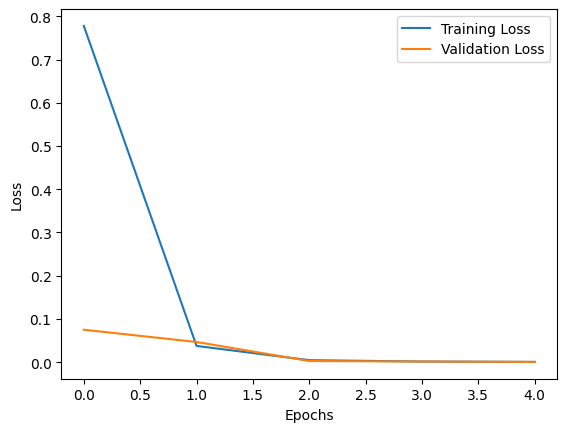

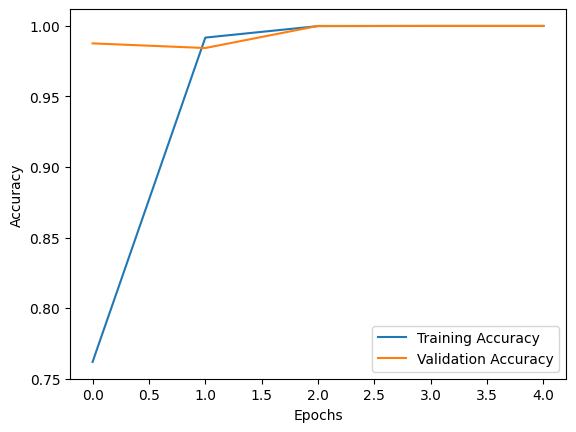

In [15]:
train_loss_values = []
train_accuracy_values = []
valid_loss_values = []
valid_accuracy_values = []

# Training loop
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch in train_dataloader:
        inputs, labels = batch['image'], batch['label']
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate accuracy and append values
    train_accuracy = correct_train / total_train
    train_accuracy_values.append(train_accuracy)

    # Calculate average training loss per epoch
    train_loss = running_loss / len(train_dataloader)
    train_loss_values.append(train_loss)

    # Validation
    model.eval()
    running_loss_valid = 0.0
    correct_valid = 0
    total_valid = 0

    for batch in valid_dataloader:
        inputs, labels = batch['image'], batch['label']
        outputs = model(inputs)
        loss_valid = criterion(outputs, labels)
        running_loss_valid += loss_valid.item()

        _, predicted_valid = torch.max(outputs.data, 1)
        total_valid += labels.size(0)
        correct_valid += (predicted_valid == labels).sum().item()

    # Calculate accuracy and append values
    valid_accuracy = correct_valid / total_valid
    valid_accuracy_values.append(valid_accuracy)

    # Calculate average validation loss per epoch
    valid_loss = running_loss_valid / len(valid_dataloader)
    valid_loss_values.append(valid_loss)

    # Print average training and validation loss per epoch
    print(f"Epoch {epoch + 1}, Training Loss : {train_loss}, Validation Loss : {valid_loss}")
    print(f"                   Training accuracy : {train_loss}, Validation accuracy : {valid_loss}")

# Plot loss graph
plt.plot(train_loss_values, label='Training Loss')
plt.plot(valid_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy graph
plt.plot(train_accuracy_values, label='Training Accuracy')
plt.plot(valid_accuracy_values, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
model_path = "models/cnn_model_2_all_train.pth"

In [ ]:
torch.save(model.state_dict(), model_path)

In [ ]:
loaded_model = SimpleCNN()
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=24, bias=True)
)

In [ ]:
sign_language_test_dataset_label = SignLanguageDataset("data/test_label.csv", transform)

In [ ]:
test_dataloader_label = DataLoader(sign_language_test_dataset_label, batch_size=batch_size, shuffle=False)

In [16]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch['image'], batch['label']
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    confusion_mat = confusion_matrix(all_labels, all_preds)

    return accuracy, confusion_mat

In [17]:
accuracy, conf_mat = evaluate_model(model, valid_dataloader)

# Afficher les résultats
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


In [ ]:
def evaluate_model_test(model, dataloader):
    model.eval()
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            images = batch['image']
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.numpy())


    return all_preds

In [ ]:
from submit_result import *

In [ ]:
pred_final = create_real_pred(preds_A, preds_B)

In [ ]:
df_test = pd.read_csv("data/test.csv")
submit = pd.concat([df_test['id'], pred_final], axis = 1)
submit

,id,label
0,0,Q
1,1,I
2,2,S
3,3,]
4,4,I
...,...,...
2995,2995,P
2996,2996,V
2997,2997,K
2998,2998,P


In [ ]:
submit.to_csv("results/submit_7_cnn_all_train.csv", index=False)

In [ ]:
accuracy, confusion_matrix = evaluate_model(model, test_dataloader_label)

# Afficher les résultats
print(f"Accuracy: {accuracy}")

TypeError: 'numpy.ndarray' object is not callable

<Axes: >

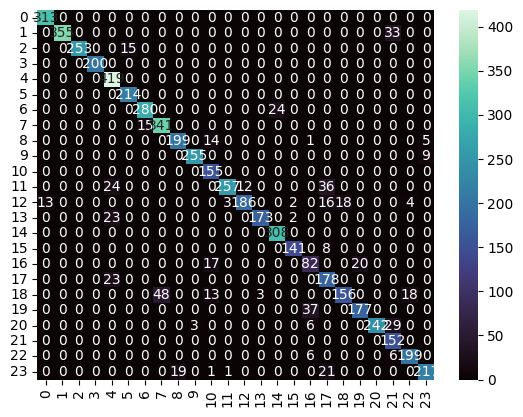

In [ ]:
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="mako")
